# 프로젝트...

[네이버 영화리뷰 감정 분석 태스크](https://github.com/e9t/nsmc/)가 있습니다. 한국어로 된 corpus를 다루어야 하므로 주로 KoNLPy에서 제공하는 형태소 분석기를 사용하여 텍스트를 전처리해서 RNN 모델을 분류기로 사용하게 되는데요.

만약 이 문제에서 tokenizer를 SentencePiece로 바꾸어 다시 풀어본다면 더 성능이 좋아질까요? KoNLPy에 있는 Mecab, kkma, Okt 등과 비교해보세요. (여러분들은 fasttext(https://wikidocs.net/22883) 로 사전훈련된 Word Vector를 사용할 수 있지만 sentencepiece와 KoNLPy에 있는 형태소로 모델을 만드는 것보다 코드 수정이 많이 일어납니다. 기본적인 태스크를 끝나고(sentencepiece - KoNLPy 형태소 비교) 도전하시는걸 추천합니다.)

- 네이버 영화리뷰 감정 분석 코퍼스에 SentencePiece를 적용시킨 모델 학습하기
- 학습된 모델로 sp_tokenize() 메소드 구현하기
- 구현된 토크나이저를 적용하여 네이버 영화리뷰 감정 분석 모델을 재학습하기
- KoNLPy 형태소 분석기를 사용한 모델과 성능 비교하기
- SentencePiece 모델의 model_type, vocab_size 등을 변경해 가면서 성능 개선 여부 확인하기
---
1. [네이버 영화리뷰 감정 분석 태스크](https://github.com/e9t/nsmc/) 데이터 다운로드, 확인
2. 데이터 전처리
3. SentencePiece를 적용시킨 모델 학습
4. 토크나이저 구현
5. 네이버 영화리뷰 감정 분석 모델 재학습?
6. 결과 확인
7. 실험 : KoNLPy 형태소 분석기를 사용한 모델과 성능 비교하기 / SentencePiece 모델의 model_type, vocab_size 등을 변경해 가면서 성능 개선 여부 확인하기

https://github.com/e9t/nsmc/blob/master/ratings_train.txt
https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt


In [52]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline 

## 1. 데이터 다운로드
---
https://github.com/e9t/nsmc/ 에서 직접 다운로드 받아서 업로드

경로: `~/aiffel/sp_tokenizer/data/ratings_train.txt`

In [37]:
# 데이터 예시 확인

import os
path_to_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/ratings_train.txt'

with open(path_to_file, "r") as f:
    raw = f.read().splitlines()

print("Data Size(문장 수):", len(raw))

print("Example:")
for sen in raw[0:100][::20]: print(">>", sen) # "::": 스텝, 20번씩 건너뛰어서 출력 ~ sequence[start:stop:step]

Data Size(문장 수): 150001
Example:
>> id	document	label
>> 3989148	약탈자를 위한 변명, 이라. 저놈들은 착한놈들 절대 아닌걸요.	1
>> 4805788	이 영화가 왜 이렇게 저평가 받는지 모르겠다	1
>> 8317483	백봉기 언제나오나요?	1
>> 9801316	아햏햏 아햏햏 아햏햏.	1


In [38]:
for i in range(10):
    print(raw[i])
    
raw[0]
raw[1]

id	document	label
9976970	아 더빙.. 진짜 짜증나네요 목소리	0
3819312	흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나	1
10265843	너무재밓었다그래서보는것을추천한다	0
9045019	교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정	0
6483659	사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다	1
5403919	막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.	0
7797314	원작의 긴장감을 제대로 살려내지못했다.	0
9443947	별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지..정말 발로해도 그것보단 낫겟다 납치.감금만반복반복..이드라마는 가족도없다 연기못하는사람만모엿네	0
7156791	액션이 없는데도 재미 있는 몇안되는 영화	1


'9976970\t아 더빙.. 진짜 짜증나네요 목소리\t0'

In [39]:
import pandas as pd

df = pd.read_csv(path_to_file, sep = '\t')

df

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
...,...,...,...
149995,6222902,인간이 문제지.. 소는 뭔죄인가..,0
149996,8549745,평점이 너무 낮아서...,1
149997,9311800,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,0
149998,2376369,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,1


In [40]:
for i in range(10):
    print(df['document'][i])

아 더빙.. 진짜 짜증나네요 목소리
흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나
너무재밓었다그래서보는것을추천한다
교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정
사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다
막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.
원작의 긴장감을 제대로 살려내지못했다.
별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지..정말 발로해도 그것보단 낫겟다 납치.감금만반복반복..이드라마는 가족도없다 연기못하는사람만모엿네
액션이 없는데도 재미 있는 몇안되는 영화
왜케 평점이 낮은건데? 꽤 볼만한데.. 헐리우드식 화려함에만 너무 길들여져 있나?


In [42]:
# 결측치 확인
df.isnull().sum()

id          0
document    5
label       0
dtype: int64

In [48]:
# 결측치 제거 : 150000 -> 149995
df = df.dropna()
df

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
...,...,...,...
149995,6222902,인간이 문제지.. 소는 뭔죄인가..,0
149996,8549745,평점이 너무 낮아서...,1
149997,9311800,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,0
149998,2376369,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,1


In [67]:
# tolist

raw = df['document'].tolist()
raw[:10]

['아 더빙.. 진짜 짜증나네요 목소리',
 '흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나',
 '너무재밓었다그래서보는것을추천한다',
 '교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정',
 '사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다',
 '막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.',
 '원작의 긴장감을 제대로 살려내지못했다.',
 '별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지..정말 발로해도 그것보단 낫겟다 납치.감금만반복반복..이드라마는 가족도없다 연기못하는사람만모엿네',
 '액션이 없는데도 재미 있는 몇안되는 영화',
 '왜케 평점이 낮은건데? 꽤 볼만한데.. 헐리우드식 화려함에만 너무 길들여져 있나?']

In [68]:
len(raw)

149995

## 데이터 확인

문장의 최단 길이: 1
문장의 최장 길이: 146
문장의 평균 길이: 35


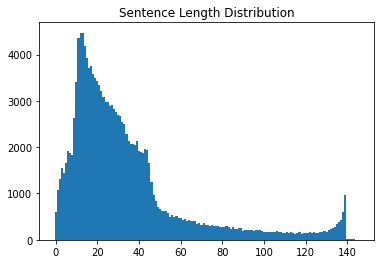

In [53]:
# 데이터 분포(문장길이 기준) 확인

min_len = 999 
max_len = 0
sum_len = 0

for sen in raw:
    length = len(sen)
    if min_len > length: min_len = length  # 최단길이 검색
    if max_len < length: max_len = length  # 최장길이 검색
    sum_len += length # 모든 문장의 길이 sum

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(raw)) # 평균길이 출력

sentence_length = np.zeros((max_len), dtype=int) # 각 인덱스에 문장 길이 저장을 위한 zero array

for sen in raw:
    sentence_length[len(sen)-1] += 1 # 해당 문장의 길이에 맞는 nparray 인덱스에 저장 후 카운팅.

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

In [57]:
# 문장길이 확인 함수

def check_sentence_with_length(raw, length):
    '''
    길이별로 문장을 확인하는 함수. 
    raw : 문장 리스트
    length : 확인할 문장의 길이
    '''
    count = 0
    
    # raw(문장 리스트)에서 한 문장씩(sen) 가져와서 아래 수행
    for sen in raw:             
        if len(sen) == length:      # 전체 문장 하나씩 불러와서 맞는 길이 검색
            print(sen)              # 그 문장 출력
            count += 1              # 카운트.
            if count > 10: return   # 10개까지 출력

check_sentence_with_length(raw, 1)

아
잼
1
4
4
굿
짱
휴
.
1
굿


ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ;

감정분석문제였으면 긍정부정에 사용할 수도 있을 것 같은데 여기서는 일단 감정분석테스크가 아니니까 버려도 될 듯

In [63]:
# 확인이 필요해 보이는 문장 모두 확인(outlier)

for idx, _sum in enumerate(sentence_length):
    # 문장의 수가 2000을 초과하는 문장 길이를 추출합니다.
    if _sum > 2000:
        print("Outlier Index:", idx+1)

Outlier Index: 10
Outlier Index: 11
Outlier Index: 12
Outlier Index: 13
Outlier Index: 14
Outlier Index: 15
Outlier Index: 16
Outlier Index: 17
Outlier Index: 18
Outlier Index: 19
Outlier Index: 20
Outlier Index: 21
Outlier Index: 22
Outlier Index: 23
Outlier Index: 24
Outlier Index: 25
Outlier Index: 26
Outlier Index: 27
Outlier Index: 28
Outlier Index: 29
Outlier Index: 30
Outlier Index: 31
Outlier Index: 32
Outlier Index: 33
Outlier Index: 34
Outlier Index: 35
Outlier Index: 36
Outlier Index: 37
Outlier Index: 38
Outlier Index: 39
Outlier Index: 40


In [64]:
cnt = 0
for idx, _sum in enumerate(sentence_length):
    print(idx, _sum)
    cnt += 1
    if cnt == 20: break


0 607
1 1071
2 1306
3 1545
4 1445
5 1653
6 1919
7 1867
8 1834
9 2636
10 3408
11 4352
12 4468
13 4472
14 4183
15 3929
16 3700
17 3751
18 3574
19 3504


In [66]:
sentence_length[10]
check_sentence_with_length(raw, 11)

백봉기 언제나오나요?
아주 모자라진 않다.
공유 존잘!!!ㅎㅎㅎ
4대2라니....최악
내 생의 최고의 영화
이딴게 한국 영화라니
번지수 잃고 갈팡질팡
너무나 감동적인 영화
내 인생 최고의 영화
참 재밌는 영화 ㅎㅎ
2.2고고하자 ㅋㅋㅋ
